## Реализация Transformer из простейших слоев

Используем только простейшие слои из `torch.nn`. Простейшие слои – это те, которые нельзя разбить на подслои. Например, `nn.Embedding`, `nn.Linear` и `nn.LayerNorm` разрешены, а `nn.TransformerEncoderLayer` и `nn.MultiheadAttention` запрещены. Также будем избегать использование циклов.

In [28]:
import torch
from torch import nn, Tensor
import numpy as np

**Надо реализовать 10 частей:**
    
1. **Embedding + Position Encoding**. Соберем в 1 класс. Используем register_buffer()
2. **Multi-Head-Attention** универсальный, для использования с некоторым изменением маски и в блоке Decoder для Cross-Attention и Masked Attention.
3. **Feed Forward Network**
4. **EncoderBlock** - из них соберем блок энкодера. Так как в Transformer блок может использовать N раз
5. **Encoder**
6. **DecoderBlock** - из них соберем блок декодера. Так как в Transformer блок может использовать N раз
7. **Decoder**
8. Функция для **маски в cross-attention**
9. Функция для **создания треугольной маски в masked-attention** + учет паддингов
10. Сбор **Transformer** из блоков ранее

## Трансформер

Трансформер состоит из двух половинок: Encoder и Decoder. Половинки очень похожи друг на друга и состоят из слоя эмбеддингов, механизма внимания и полносвязной сети.

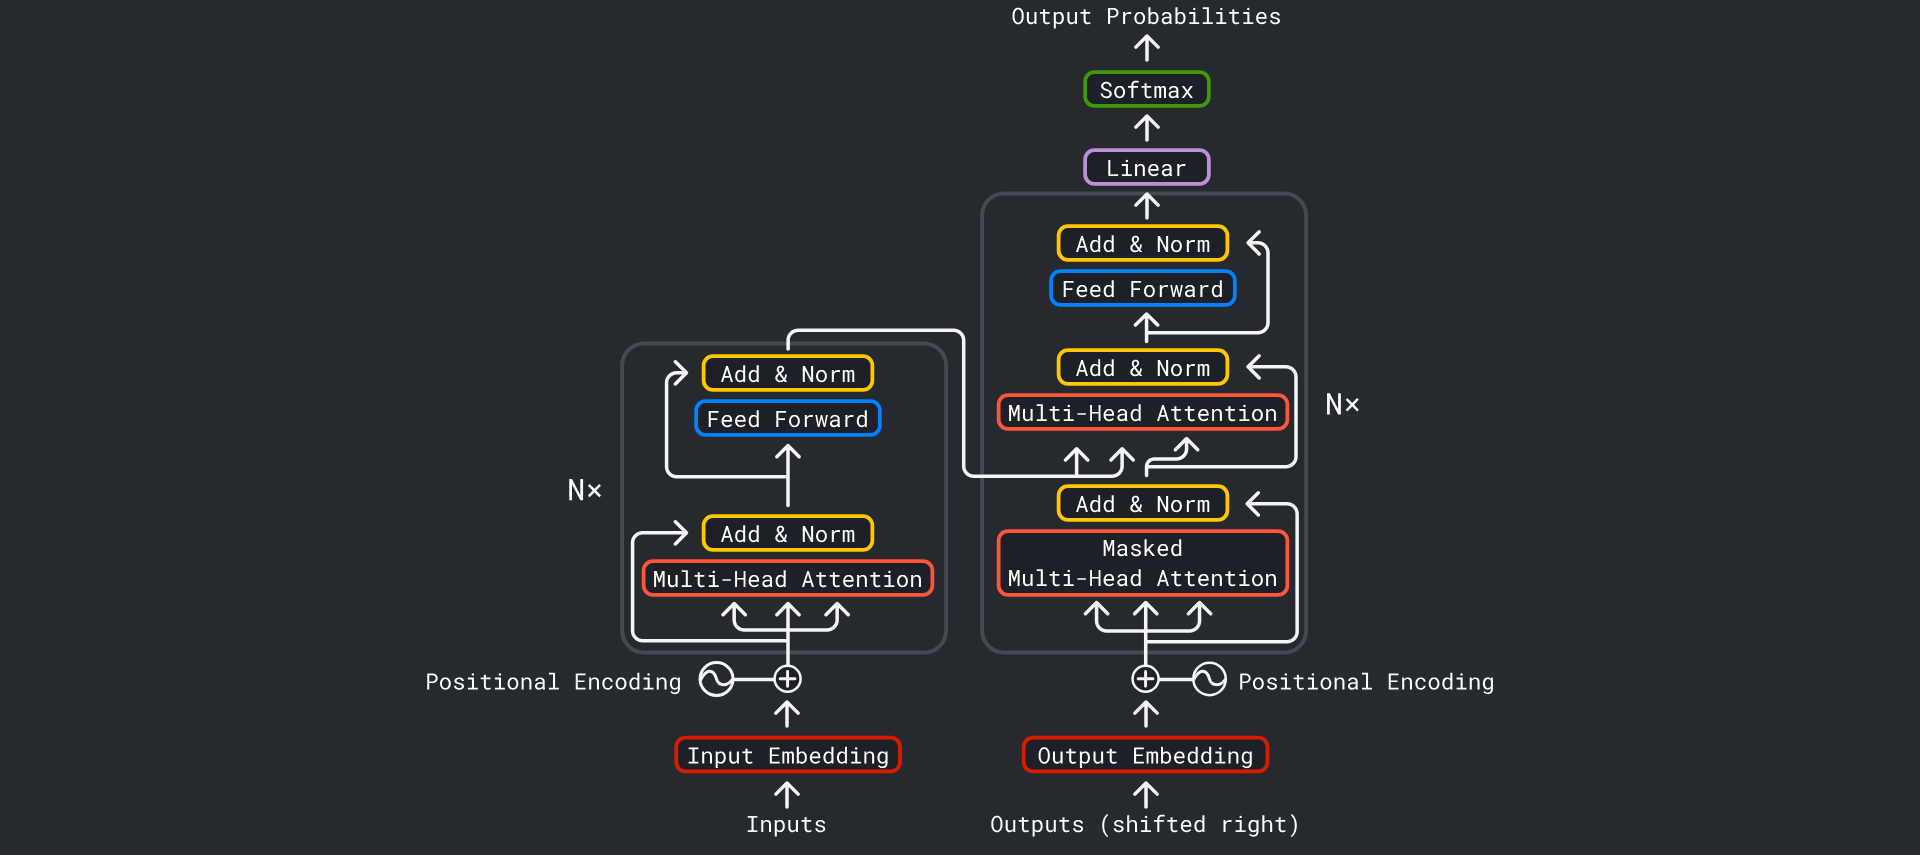

При реализации этой архитектуры стараемся избегать дуплекации кода. Для этого реализуем каждый слой отдельно, чтобы потом собрать модель как конструктор. Начнем со слоя эмбеддингов.

Все размерности выхода каждого слоя в Трансформере совпадают с размерностями входа. Это позволяет использовать подряд сколько угодно слоев.



### Эмбеддинги

Слой эмбеддингов состоит из двух компонент: эмбеддингов токенов и эмбеддингов их позиций. Эмбеддинги позиций нужны для того, чтобы механизм внимания понимал, где расположены токены. Оба вида эмбеддингов объединяются с помощью простого суммирования, (сейчас уже придуманы более элегантные способы). Однако реализуем его именно в этом виде. В конце к эмбеддингам применяется `LayerNorm` и `Dropout`.

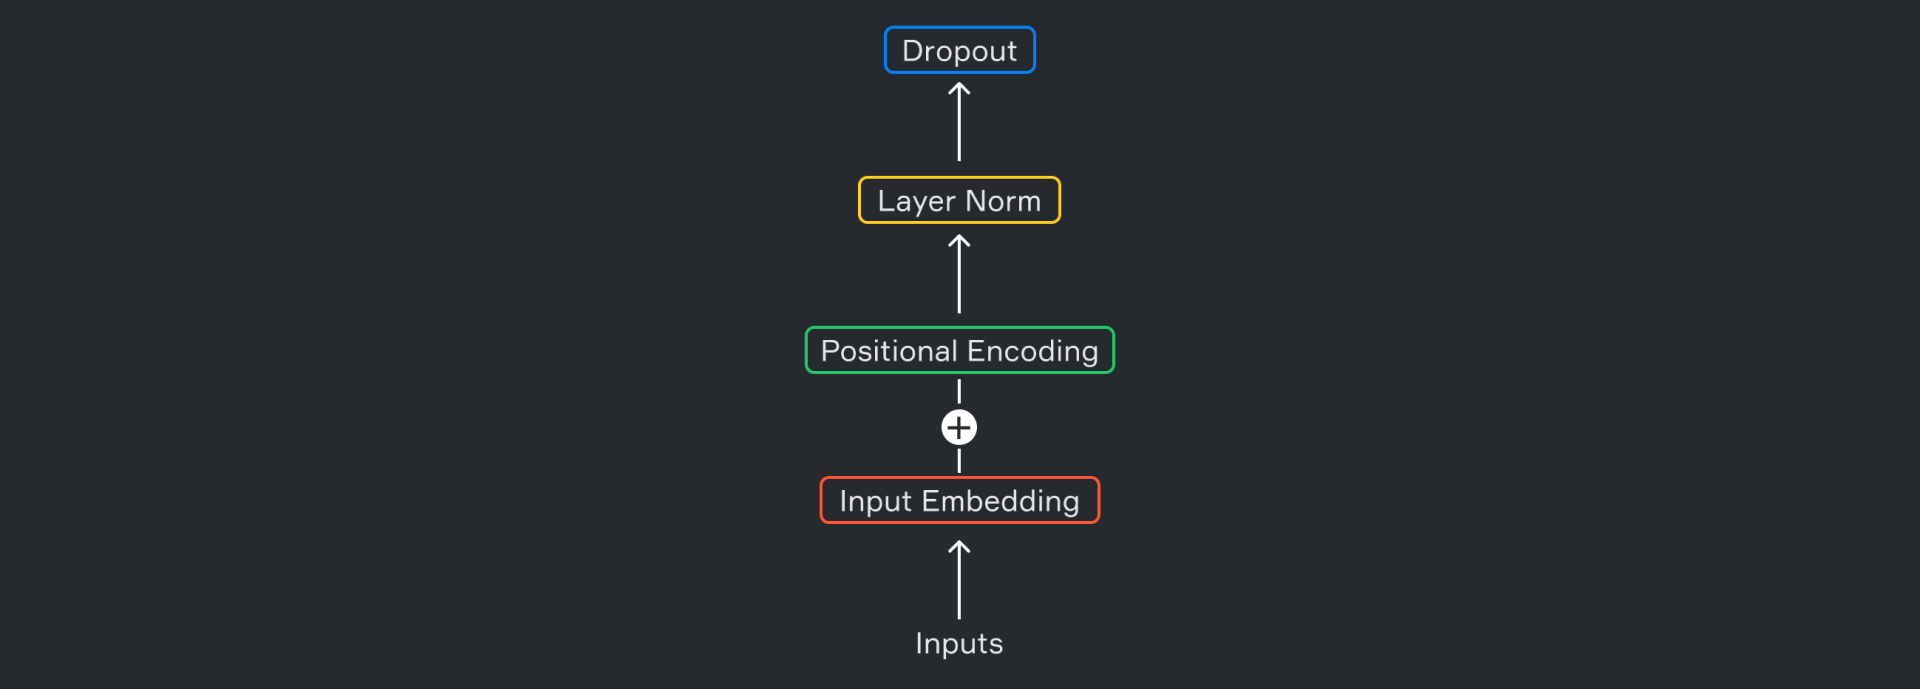

__Часть 1.__ Реализуем класс `Embedding`, реализующий описанную схему. Для хранения индексов позиций полезно использовать `self.register_buffer`. Это специальный метод из `nn.Module` нужный для того, чтобы `torch` воспринимал переменную как часть модели. Например, при переводе модели на GPU такие переменные тоже будут переноситься на GPU.

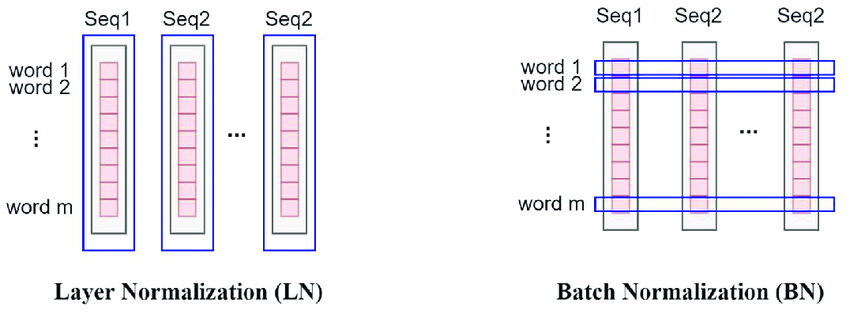

In [29]:
class Embedding(nn.Module):
    """
    Переводит токены в эмбеддинги Трансформера,
    суммируя эмбеддинги токенов и их позиций
    """

    def __init__(self, vocab_size, hidden_size, max_len, drop_prob=0.1):
        """
        vocab_size: размер словаря
        hidden_size: размер скрытого слоя
        max_len: максимальная возможная длина текста
        drop_prob: вероятность удаления нейрона в dropout
        """
        super().__init__()
        # sequence_position (1, max_len)
        self.register_buffer("sequence_position", torch.arange(0, max_len).unsqueeze(0))
        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=hidden_size)
        self.position_embedding = nn.Embedding(num_embeddings=max_len,
                                               embedding_dim=hidden_size)
        
        self.layer_norm = nn.LayerNorm(normalized_shape=hidden_size)
        self.dropout = nn.Dropout(drop_prob)
        

    def forward(self, input_ids) -> Tensor:
        """
        input_ids: Tensor[bs, seq_len] – индексы токенов текста
        """
        assert input_ids.ndim == 2

        embedding = self.embedding(input_ids)
        position_embedding = self.position_embedding(self.sequence_position[:, :input_ids.size(1)])
        
        embedding += position_embedding
        
        layer_norm_embedding = self.layer_norm(embedding)
        
        
        return self.dropout(layer_norm_embedding)

## Механизм внимания

Механизм внимания – основная компонента Трансформера и по совместительству самый сложный слой. Выход Attention считается по формуле
$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_h}}\right) V,
$$
где $d_h$ – размерность головы.

Визуально это выглядит вот так:

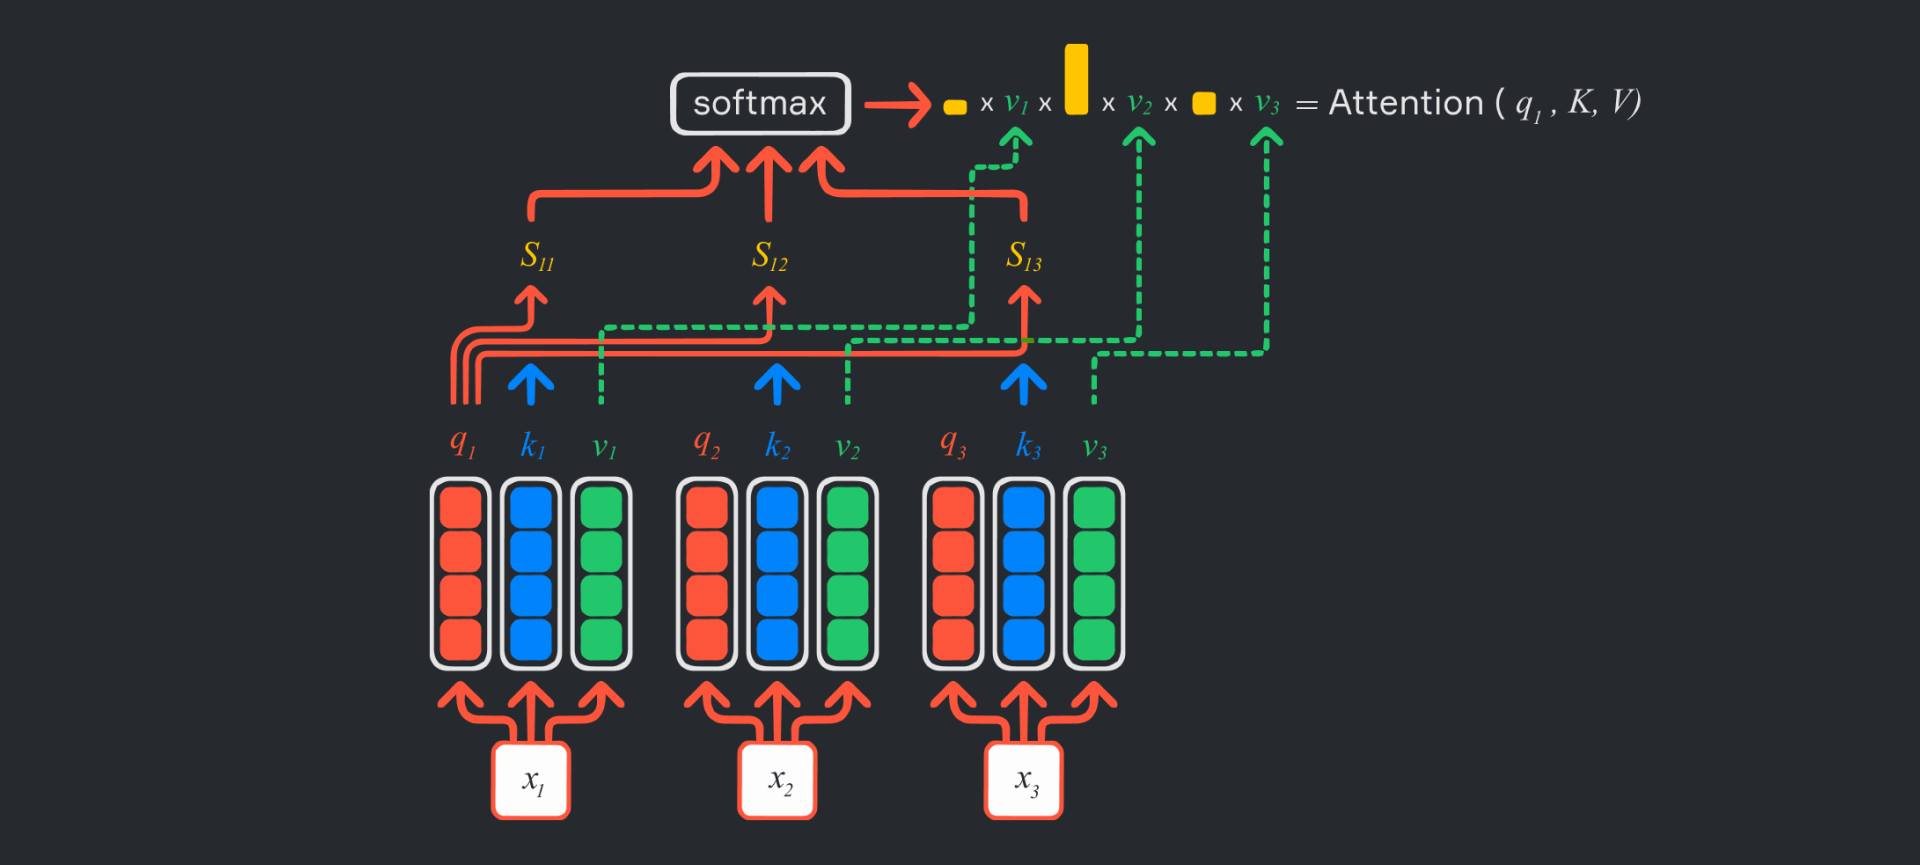
Все значения $Q$, $K$ и $V$ получаются путем применения соответствующих линейных слоев ко входу. Иногда эти линейные слои меняют размерность векторов, но мы не будем этого делать.

Multi-Head модификация механизма внимания работает почти так же, за исключением того, что каждый из векторов $Q$, $K$ и $V$ делится на `n_head` частей.

\begin{align}
&\text{head}^{(i)} = \text{Attention}(Q^{(i)}, K^{(i)}, V^{(i)})\\
&\text{MultiHead}(Q, K, V) = W_o \times [\text{head}^{(1)}, \dots, \text{head}^{(h)}]
\end{align}

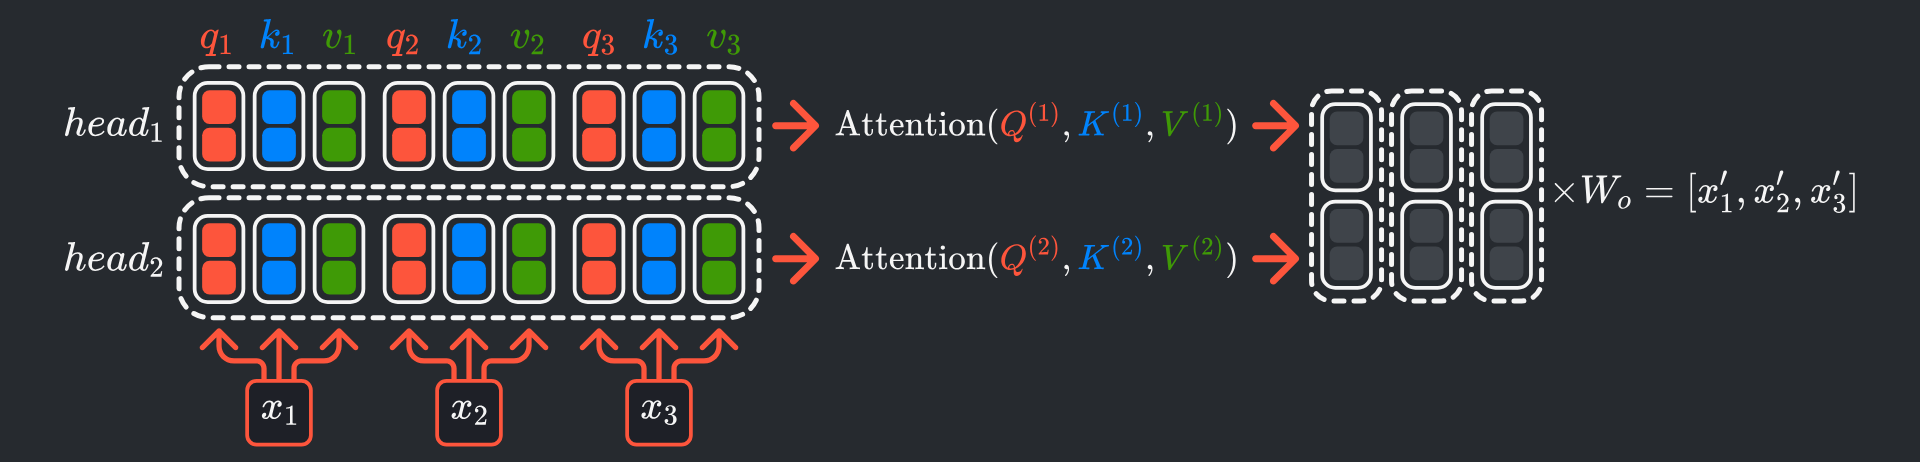


__Часть 2.__ Реализуем класс `MultiHeadAttention`. Его метод `forward` принимает входы для векторов `q`, `k` и `v` отдельно вместо одного на всех. Это нужно для того, чтобы потом переиспользовать этот же класс для Cross Attention в Decoder. Трансформер может переобучаться, поэтому применим `Dropout` к посчитанным вероятностям (выход sotfmax) механизма внимания.

Чтобы разделить вектор размера `d` на `n` векторов размера `d'` можно использовать `Tensor.view(n, d')`. Дальше можно совершать с ним любые операции умножения. Главное, чтобы последние две размерности перемножаемых тензоров [правильно соотносились](https://pytorch.org/docs/stable/generated/torch.matmul.html).


__Внимание:__ при подсчете внимания мы используем маски внимания, чтобы запретить модели смотреть на некоторые токены. Например, токены паддинга. Более подробное описание этих масок будет в частях 8 и 9.

In [30]:
# разделили 1 тензор на 8 частей через view
torch.randn((512)).view(8, 64).shape

torch.Size([8, 64])

Некоторые операции, такие как .transpose() или .permute(), изменяют представление тензора без изменения фактических данных. В результате тензор может стать не непрерывным (non-contiguous). Перед выполнением операций, которые требуют **непрерывного тензора** (например, .view()), необходимо вызвать .contiguous()

In [31]:
class MultiHeadAttention(nn.Module):
    """
    Реализует Multi-Head Self-Attention слой Трансформера.
    """
    def __init__(self, hidden_size, n_head, drop_prob=0.1):
        """
        hidden_size: размер скрытого слоя
        n_head: число голов внимания
        drop_prob: вероятность удаления нейрона в dropout
        """
        super().__init__()

        assert hidden_size % n_head == 0

        self.hidden_size = hidden_size
        self.d_h = np.sqrt(hidden_size // n_head)
        self.n_head = n_head
        
        # используется по view при разбиании на головы
        self.H_division_nhead = hidden_size // n_head
        
        # все 4 матрицы имеют размерность (H, H)
        self.query = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.key = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.value = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        # выходной слой для применения к конкатенированным головам
        self.out = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        
        self.dropout = nn.Dropout(drop_prob)

    def forward(self, q, k, v, attention_mask=None) -> Tensor:
        """
        q, k, v: Tensor[bs, seq_len, hidden_size] – входные аргументы для соответствующих линейных слоев
        attention_mask: Tensor[bs, 1, 1 or seq_len, seq_len] – маска внимания, содержащая значения 0 и -inf;
                                                               добавляется к скорам механизма внимания (до softmax)
        """
        assert q.ndim == k.ndim == v.ndim == 3
        assert attention_mask.ndim == 4
        
        # q, k, v: (N, L, H)
        # 1. Cчитаем матрицы K, Q и V и разделяем их на головы.
        
        bs = q.size(0)
        
        # Размерность каждой матрицы: [bs, seq_len, n_head, head_dim]
        # но также надо учесть transpose для n_head и seq_len, чтобы каждая голова была независима
        # по итогу [bs, n_head, seq_len, head_dim]
        q_heads = self.query(q).view(bs, -1, self.n_head, self.H_division_nhead).transpose(1, 2)
        k_heads = self.key(k).view(bs, -1, self.n_head, self.H_division_nhead).transpose(1, 2)
        v_heads = self.value(v).view(bs, -1, self.n_head, self.H_division_nhead).transpose(1, 2)

        # 2. Считаем attention_scores: Q * K^T / sqrt{head_dim}
        # Размерность результата: [bs, n_head, seq_len, seq_len]
        
        # matmul автоматически работает по последним двум измерениям тензоров
        attention_heads_scores = torch.matmul(q_heads, k_heads.transpose(2, 3)) / self.d_h
        
        # 3. Добавляем attention_mask к полученным скорам, чтобы занулить те из них, на которые нельзя смотреть
        
        
        if attention_mask is not None:
            attention_heads_scores += attention_mask
        
        # 4. Считаем attention_probs: softmax(attention_scores)
        # Softmax применяем к последней размерности
        
        attention_heads_probs = torch.nn.functional.softmax(attention_heads_scores, dim=-1)   
        
        
        # 5. Добавляем dropout к полученным вероятностям
        attention_heads_probs = self.dropout(attention_heads_probs)
        
        # 6. Считаем выход внимания: attention_heads_probs * V
        # attention_heads_probs: [bs, n_head, seq_len, seq_len]
        # V:               [bs, n_head, seq_len, head_dim]
        # Размерность результата: [bs, n_head, seq_len, head_dim]
        
        attention_heads = torch.matmul(attention_heads_probs, v_heads)
        

        # 7. Конкатенируем обратно векторы всех голов, получаем размерность [bs, seq_len, hidden_size]
        # это можно сделать снова через view, предварительно переставив размерность головы в изначальное место
        # и применив contiguousд для создания копии тензора для корректной работы view
        
        attention = attention_heads.permute(0, 2, 1, 3).contiguous().view(bs, -1, self.hidden_size)
        output = self.out(attention)
         
        # 8. Применяем последний линейный слой
        # Размерность результата: [bs, seq_len, hidden_size]

        return output

### Feed Forward Network

FFN – слой, состоящий из двух полносвязных слоев с расширением. Реализуем его сразу со skip-connection и Layer Norm для того, чтобы не добавлять их потом отдельно. Также к выходу полносвязной сети добавим Dropout, чтобы контролировать переобучение. В качестве активации в FFN используется ReLU.

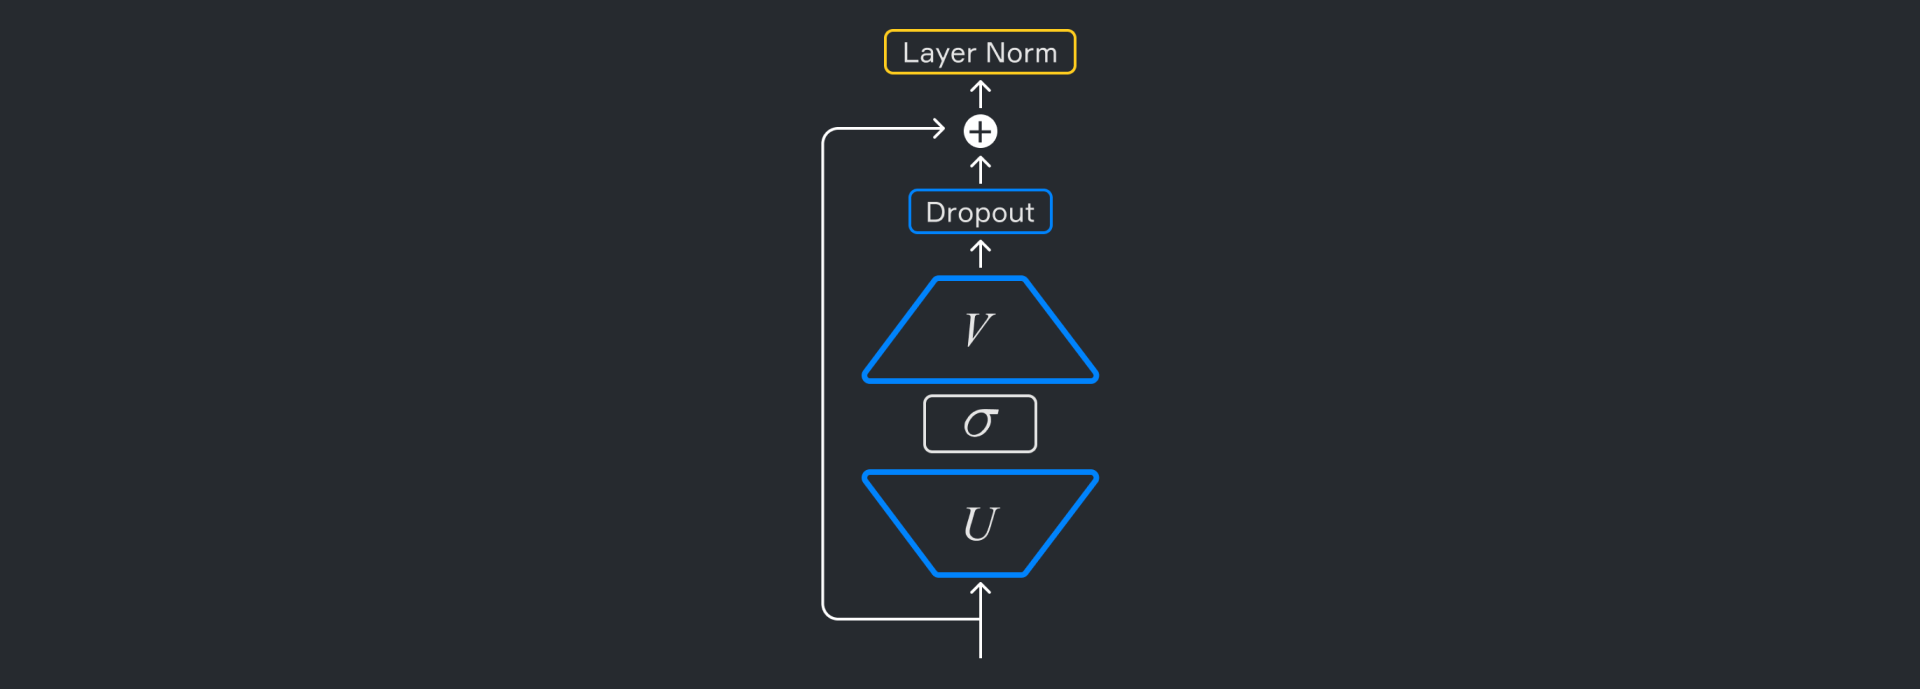

__Часть 3.__ Реализуем класс `FeedForward` по описанной схеме.

In [32]:
class FeedForward(nn.Module):
    """
    Реализует Feed Forward Network слой Трансформера c skip-connection и нормализацией.
    """
    def __init__(self, hidden_size, intermediate_size, drop_prob=0.1):
        """
        hidden_size: размер скрытого слоя
        intermediate_size: размер промежуточного слоя
        drop_prob: вероятность удаления нейрона в dropout
        """
        super().__init__()

        self.U_layer = nn.Linear(in_features=hidden_size, out_features=intermediate_size)
        self.V_layer = nn.Linear(in_features=intermediate_size, out_features=hidden_size)
        
        self.dropout = nn.Dropout(drop_prob)
        self.layer_norm = nn.LayerNorm(hidden_size)
        
        self.activation = nn.ReLU()
        

    def forward(self, hidden_states) -> Tensor:
        """
        hidden_states: Tensor[bs, seq_len, hidden_size] – входное представление текста
        """
        assert hidden_states.ndim == 3

        residual = hidden_states
        
        U_output = self.activation(self.U_layer(hidden_states))
        V_output = self.V_layer(U_output)
        
        dropout_output = self.dropout(V_output)
        
        skip_connection = residual + dropout_output
        
        return self.layer_norm(skip_connection)
        

### Encoder

Encoder состоит из слоя эмбеддингов и повторяющихся блоков Encoder'a. Слой эмбеддингов у нас уже есть, поэтому осталось реализовать блоки. Каждый из них выглядит как слой Feed Forward Network идущий за Multi-Head Self-Attention со skip-connection и нормализацией.

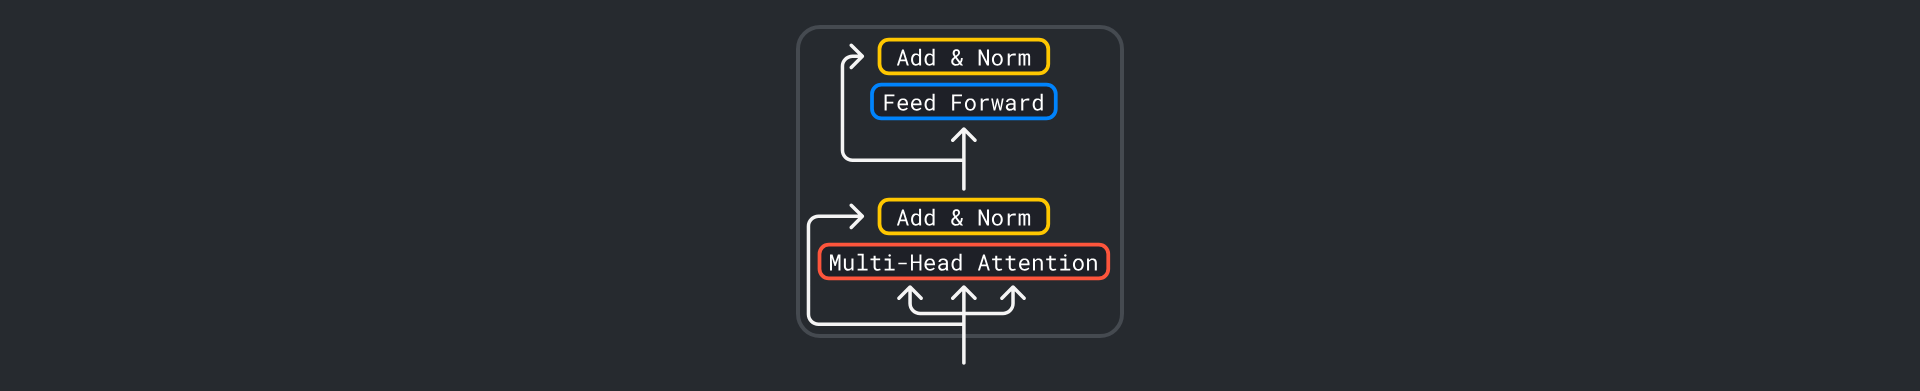

__Часть 4.__ Реализуем класс `EncoderBlock` по описанной схеме. К выходам механизма внимания добавим Dropout аналогично тому, как это было сделано в `FeedForward`. Так как в `FeedForward` мы уже добавили skip-connection, в него надо обернуть только механизм внимания. Внимание! Encoder тоже использует маску внимания для того, чтобы не смотреть на паддинги.

In [33]:
class EncoderBlock(nn.Module):
    """
    Реализует блок Encoder'a.
    """
    def __init__(self, hidden_size, intermediate_size, n_head, drop_prob=0.1):
        """
        hidden_size: размер скрытого слоя
        intermediate_size: размер промежуточного слоя
        n_head: число голов внимания
        """
        super().__init__()

        self.FFN = FeedForward(hidden_size, intermediate_size, drop_prob)
        self.MHA = MultiHeadAttention(hidden_size, n_head, drop_prob)
        
        self.dropout = nn.Dropout(drop_prob)
        self.layer_norm = nn.LayerNorm(hidden_size)

    def forward(self, hidden_states, attention_mask) -> Tensor:
        """
        hidden_states: Tensor[bs, seq_len, hidden_size] – входное представление текста
        attention_mask: Tensor[bs, 1, 1, seq_len] – маска внимания, содержащая значения 0 и -inf
        """
        assert hidden_states.ndim == 3
        assert attention_mask.ndim == 4
        
        residuals = hidden_states
        
        # расчеты для обработки multi-head-attention с учетом dropout, skip-connection и layer_norm
        mha_block = self.MHA.forward(q=hidden_states,
                                     k=hidden_states,
                                     v=hidden_states,
                                     attention_mask=attention_mask)
        
        hidden_states = self.dropout(mha_block)
        hidden_states = self.layer_norm(hidden_states + residuals)
        
        # расчеты для Feed Forward Network
        feed_forward_network = self.FFN(hidden_states)
        
        return feed_forward_network
        

Отлично, теперь можем собрать весь Encoder Трансформера целиком. Он состоит из слоя эмбеддингов и нескольких одинаковых блоков `EncoderBlock`.

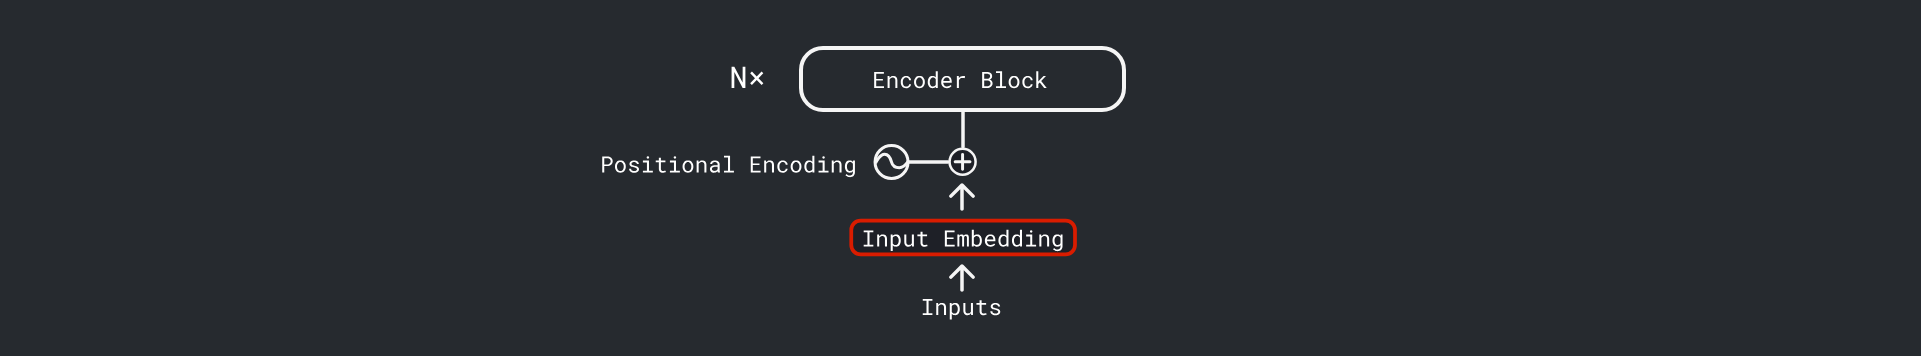

__Часть 5.__ Реализуем класс `Encoder` из написанных блоков.

В ModuleList нет forwardметода, поэтому внутренние слои не связаны. 

In [34]:
class Encoder(nn.Module):
    """
    Encoder Трансформера.
    """
    def __init__(self, vocab_size, max_len, hidden_size,
                 intermediate_size, n_head, n_layers, drop_prob=0.1):
        """
        vocab_size: размер словаря
        max_len: максимальная возможная длина текста
        hidden_size: размер скрытого слоя
        intermediate_size: размер промежуточного слоя
        n_head: число голов внимания
        n_layers: число блоков Encoder
        drop_prob: вероятность удаления нейрона в dropout
        """
        super().__init__()
        
        self.n_layers = n_layers
        
        self.Embedding = Embedding(vocab_size, hidden_size, max_len, drop_prob)
        
        self.Encoder_block_list = nn.ModuleList([
                                                EncoderBlock(
                                                    hidden_size,
                                                    intermediate_size,
                                                    n_head, drop_prob)
                                                for _ in range(n_layers)])

    def forward(self, input_ids, attention_mask=None) -> Tensor:
        """
        input_ids: Tensor[bs, seq_len] – индексы токенов текста
        attention_mask: Tensor[bs, 1, 1, seq_len] – маска внимания, содержащая значения 0 и -inf
        """
        assert input_ids.ndim == 2
        assert attention_mask.ndim == 4
        
        hidden_states = self.Embedding.forward(input_ids)
        for i in range(self.n_layers):
            hidden_states = self.Encoder_block_list[i].forward(hidden_states, attention_mask)
        return hidden_states

### Decoder

Decoder состоит из слоя эмбеддингов и блоков Decoder'а. Блок Decoder'а отличается только наличием дополнительного слоя внимания, Cross Attention, и специальным видом маски. В остальном это такой же Encoder. Cross Attention принимает в качестве `k` и `v` выход Encoder'a, и только `q` получается из состояний Decoder'a.

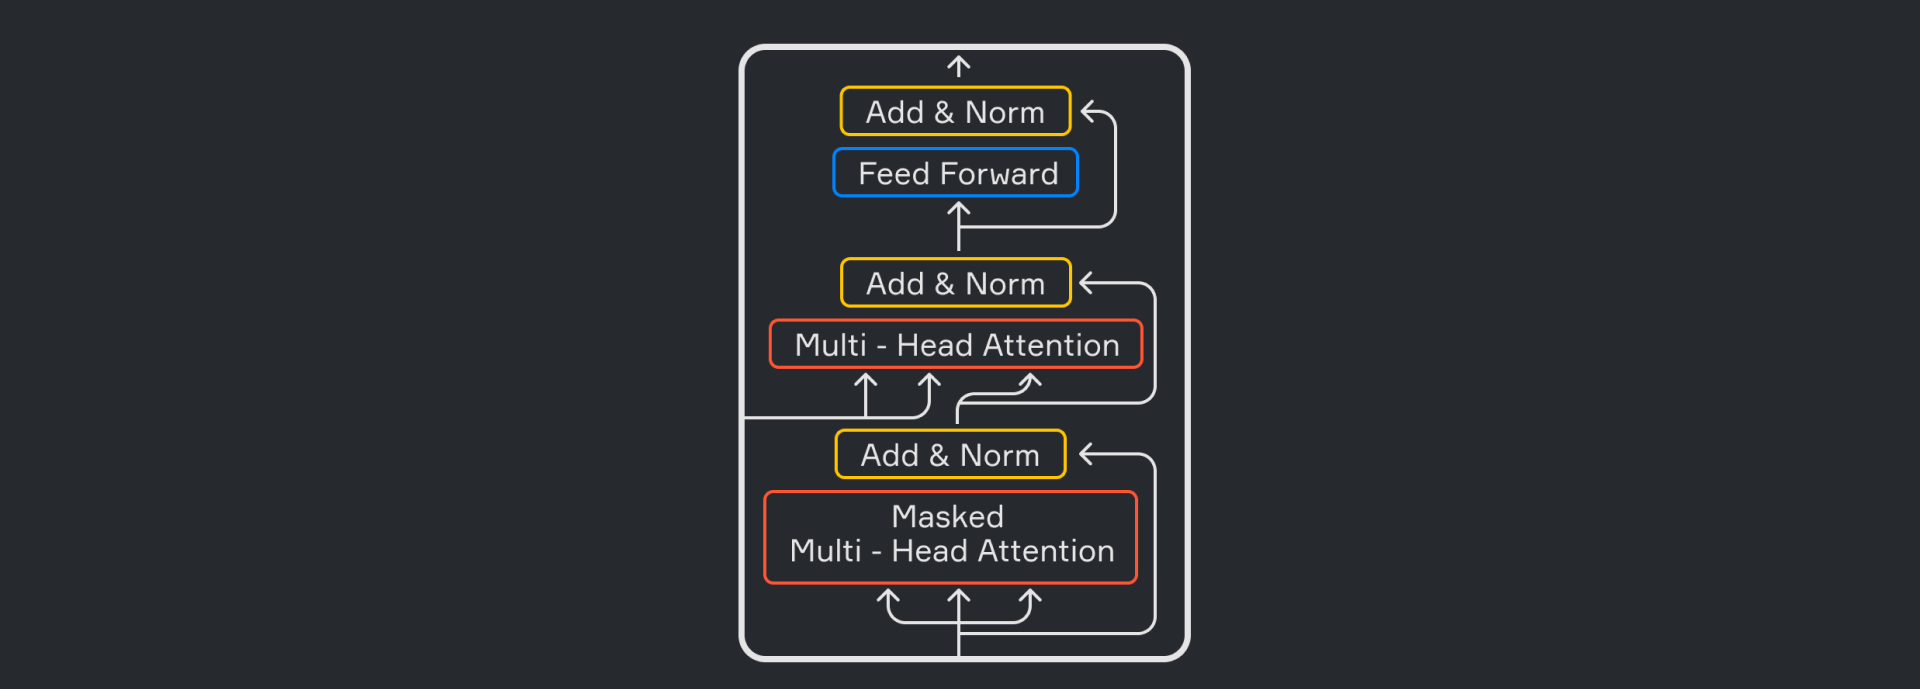

__Часть 6.__ Реализуем класс `DecoderBlock` по описанной схеме. Так же как и в `EncoderBlock` к выходам обоих механизмов внимания добавим Dropout, skip-connection и нормализацию.

In [35]:
class DecoderBlock(nn.Module):
    """
    Реализует блок Decoder'a.
    """
    def __init__(self, hidden_size, intermediate_size, n_head, drop_prob=0.1):
        """
        hidden_size: размер скрытого слоя
        intermediate_size: размер промежуточного слоя
        n_head: число голов внимания
        drop_prob: вероятность удаления нейрона в dropout
        """
        super().__init__()

        self.FFN = FeedForward(hidden_size, intermediate_size, drop_prob)
        
        self.masked_MHA = MultiHeadAttention(hidden_size, n_head, drop_prob)
        self.cross_MHA = MultiHeadAttention(hidden_size, n_head, drop_prob)
        
        self.dropout = nn.Dropout(drop_prob)
        self.layer_norm_1 = nn.LayerNorm(hidden_size)
        self.layer_norm_2 = nn.LayerNorm(hidden_size)



    def forward(self, hidden_states, attention_mask, encoder_hidden_states, encoder_attention_mask) -> Tensor:
        """
        hidden_states: Tensor[bs, trg_seq_len, hidden_size] – входное представление целевого текста
        attention_mask: Tensor[bs, 1, trg_seq_len, trg_seq_len] – маска внимания Decoder'a
        encoder_hidden_states: Tensor[bs, src_seq_len, hidden_size] – выход последнего слоя Encoder
        encoder_attention_mask: Tensor[bs, 1, 1, src_seq_len] – маска внимания Encoder'a
        """
        assert hidden_states.ndim == encoder_hidden_states.ndim == 3
        assert attention_mask.ndim == encoder_attention_mask.ndim == 4
        


        residual = hidden_states
        
        masked_mha_output = self.masked_MHA.forward(q=hidden_states,
                                                    k=hidden_states,
                                                    v=hidden_states,
                                                    attention_mask=attention_mask)
        
        hidden_states = self.dropout(masked_mha_output)
        
        hidden_states = self.layer_norm_1(hidden_states + residual)
        
        # испольузем текущее состояние, чтобы прокинуть дальше
        residual = hidden_states
        
        cross_mha = self.cross_MHA.forward(q=hidden_states,
                                           k=encoder_hidden_states,
                                           v=encoder_hidden_states,
                                           attention_mask=encoder_attention_mask)
        
        hidden_states = self.dropout(cross_mha)
        
        hidden_states = self.layer_norm_2(hidden_states + residual)
        
        feed_forward_output = self.FFN.forward(hidden_states)
        
        return feed_forward_output
        
        

Соберем Decoder из полученных блоков. На выходе Decoder предсказывает токены, поэтому к выходам финально блока применяется полносвязный слой.

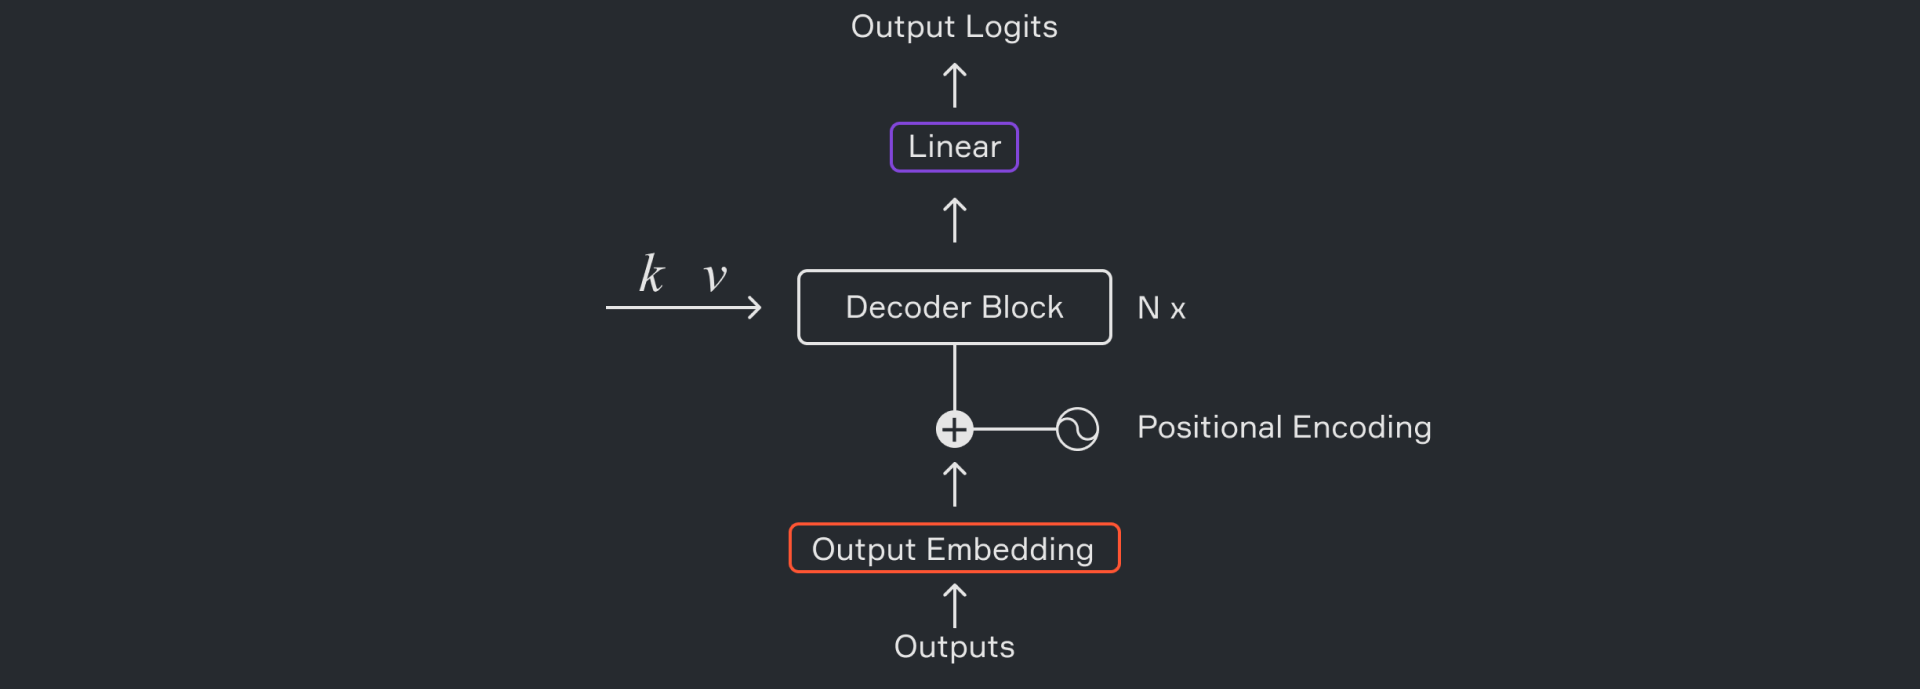

__Часть 7.__ Реализуем класс `Decoder` из написанных блоков.

In [36]:
class Decoder(nn.Module):
    """
    Decoder Трансформера.
    """
    def __init__(self, vocab_size, max_len, hidden_size,
                 intermediate_size, n_head, n_layers, drop_prob=0.1):
        """
        vocab_size: размер словаря
        max_len: максимальная возможная длина текста
        hidden_size: размер скрытого слоя
        intermediate_size: размер промежуточного слоя
        n_head: число голов внимания
        n_layers: число блоков Decoder
        """
        super().__init__()
        
        self.n_layers = n_layers

        self.embedding = Embedding(vocab_size, hidden_size, max_len, drop_prob)

        self.decoder_block_list = nn.ModuleList([DecoderBlock(hidden_size,
                                                              intermediate_size,
                                                              n_head,
                                                              drop_prob)
                                                 for _ in range(n_layers)])
        
        self.output_logits = nn.Linear(in_features=hidden_size, out_features=vocab_size)

    def forward(self, input_ids, attention_mask, encoder_hidden_states, encoder_attention_mask) -> Tensor:
        """
        input_ids: Tensor[bs, seq_len] – индексы токенов текста
        attention_mask: Tensor[bs, 1, trg_seq_len, trg_seq_len] – маска внимания Decoder'a
        encoder_hidden_states: Tensor[bs, src_seq_len, hidden_size] – выход последнего слоя Encoder
        encoder_attention_mask: Tensor[bs, 1, 1, src_seq_len] – маска внимания Encoder'a
        """
        assert input_ids.ndim == 2
        assert encoder_hidden_states.ndim == 3
        assert attention_mask.ndim == encoder_attention_mask.ndim == 4

        hidden_states = self.embedding(input_ids)
        
        for i in range(self.n_layers):
            hidden_states = self.decoder_block_list[i].forward(hidden_states,
                                                               attention_mask,
                                                               encoder_hidden_states,
                                                               encoder_attention_mask)
        
        logits = self.output_logits(hidden_states)
        
        return logits
        
        

In [37]:
torch.randn(10).view(1, 1, -1, 10).shape

torch.Size([1, 1, 1, 10])

In [38]:
test = torch.tensor([1, 2, 3, -1, -2, 0])
test

tensor([ 1,  2,  3, -1, -2,  0])

In [39]:
torch.where(test > 0, 9, 1)

tensor([9, 9, 9, 1, 1, 1])

In [40]:
torch.finfo(torch.float).min

-3.4028234663852886e+38

### Маски внимания

Во всех предыдущих частях предполагалось, что все маски внимания имеют 4 размерности, они имеют 4 размерности для того, чтобы их можно было складывать со скорами внимания (они имеют размерность `[bs, n_heads, seq_len, seq_len]`). В случае Encoder для того, чтобы получить такую маску из стандартной с двумя размерностями, достаточно добавить две пустые размерности в середину.

__Часть 8.__ Реализуем функцию `get_extended_attention_mask`, которая принимает аргументы `attention_mask` и `dtype` и возвращает расширенную матрицу `attention_mask`, заменяя все 0 на `-inf` и все 1 на 0.  Аргумент `dtype` нужен для получения значения `-inf`. В `torch` использование `-torch.inf` может сломать все операции, потому что это неопределенное значение. Вместо этого используем `torch.finfo(dtype).min`.

In [41]:
# attention_mask: [N, seq_len]
def get_extended_attention_mask(attention_mask, dtype=torch.float):
    N = attention_mask.size(0)
    seq_len = attention_mask.size(1)
    
    extended_attention_mask = attention_mask.view(N, 1, 1, seq_len)
    
    # заменяем 1 на 0 и 0 на -inf
    
    return (extended_attention_mask != 1).to(dtype) * torch.finfo(dtype).min

In [42]:
attention_mask = torch.tensor([
    [1, 1, 1, 0],
    [1, 0, 0, 0],
    [1, 1, 1, 1],
])
extended_mask = get_extended_attention_mask(attention_mask)
torch.round(extended_mask, decimals=2)

tensor([[[[-0., -0., -0., -inf]]],


        [[[-0., -inf, -inf, -inf]]],


        [[[-0., -0., -0., -0.]]]])

Матрица маски внимания: Это  N × N  матрица, где строки соответствуют "запрашивающим" токенам (которые обращают внимание), а столбцы — "доступным" токенам (на которые обращают внимание). Каждая ячейка  M_(i,j)  определяет, может ли  i -й токен обратить внимание на  j -й токен:

   • 0: внимание разрешено.

   • -∞: внимание запрещено.

С матрицей внимания Decoder все сложнее. Decoder'у запрещается смотреть вперед при предсказании следующих токенов, поэтому в нем используется треугольная маска внимания. Вероятности механизма внимания в каждой строке показывают, на какие другие токены может смотреть токен, соответствующий это строке. Так что маска, которую добавляем будет выглядить так:

\begin{bmatrix}
0 & -\infty & -\infty\\
0 & 0 & -\infty \\
0 & 0 & 0
\end{bmatrix}

Ее форма будет иметь такой вид: `[bs, 1, seq_len, seq_len]`. Одна пустая размерность сохраняется, так как для всех голов маска одна и та же.

__Часть 9.__ Реализуем функцию `get_causal_extended_attention_mask` выдающую треугольную расширенную маску внимания. Функция принимает те же аргументы, что и предыдущая: `attention_mask` и `dtype`. Все 0 и 1 из `attention_mask`, которые появляются там из-за паддингов, переносятся и в расширенную маску. То есть токены не могут смотреть не только вперед, но и на токены паддингов. Конечно же, 0 и 1 заменяются на `-inf` и 0 аналогично предыдущей функции.

In [ ]:
def get_causal_extended_attention_mask(attention_mask, dtype=torch.float):    
    device = attention_mask.device
    batch_size, seq_len = attention_mask.shape

    seq_ids = torch.arange(seq_len, device=device)
    causal_mask = seq_ids[None, None, :].repeat(batch_size, seq_len, 1) <= seq_ids[None, :, None]    
    causal_mask = causal_mask.to(attention_mask.dtype)

    extended_attention_mask = causal_mask[:, None, :, :] * attention_mask[:, None, None, :].to(dtype=dtype)
    
    extended_attention_mask = (1.0 - extended_attention_mask) * torch.finfo(dtype).min
    return extended_attention_mask

In [45]:
attention_mask = torch.tensor([
    [1, 1, 1, 0],
    [1, 0, 0, 0],
    [1, 1, 1, 1],
])
causal_extended_mask = get_causal_extended_attention_mask(attention_mask)
torch.round(causal_extended_mask, decimals=2)

tensor([[[[-inf, -inf, -inf, -inf],
          [-inf, -inf, -inf, -inf],
          [-inf, -inf, -inf, -inf],
          [-inf, -inf, -inf, 0.]]],


        [[[-inf, -inf, -inf, -inf],
          [-inf, 0., -inf, -inf],
          [-inf, 0., 0., -inf],
          [-inf, 0., 0., 0.]]],


        [[[-inf, -inf, -inf, -inf],
          [-inf, -inf, -inf, -inf],
          [-inf, -inf, -inf, -inf],
          [-inf, -inf, -inf, -inf]]]])

### Трансформер

Соберем всю эту красоту в Трансформер.

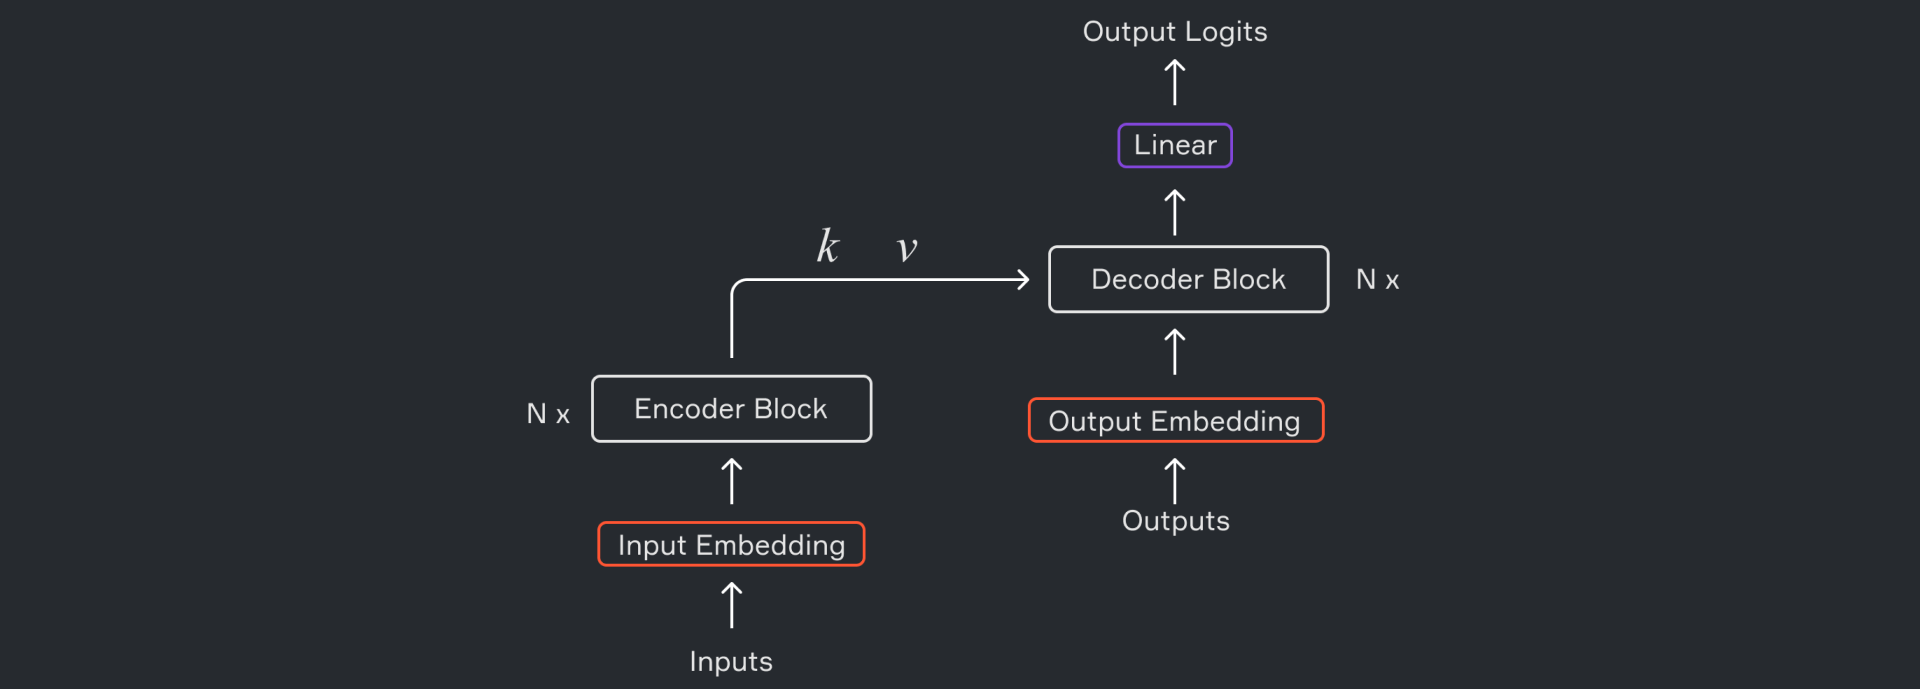

__Часть 10.__ Напишем класс `Transformer`. В методе `forward` маски внимания конвертируются в расширенные маски с помощью написанных функций.

In [46]:
class Transformer(nn.Module):
    def __init__(self, encoder_vocab_size, decoder_vocab_size, hidden_size, n_head,
                 intermediate_size, encoder_max_len, decoder_max_len, n_layers, drop_prob=0.1):
        super().__init__()
        """
        Все параметры означают то же самое, что и в предыдущих классах
        """

        self.encoder = Encoder(encoder_vocab_size, encoder_max_len, hidden_size,
                               intermediate_size, n_head, n_layers, drop_prob)
        
        self.decoder = Decoder(decoder_vocab_size, decoder_max_len, hidden_size,
                               intermediate_size, n_head, n_layers, drop_prob)

    def forward(self, src_input_ids, trg_input_ids, src_attention_mask=None, trg_attention_mask=None) -> Tensor:
        """
        src_input_ids: Tensor[bs, src_seq_len] – индексы токенов входного текста
        trg_input_ids: Tensor[bs, trg_seq_len] – индексы токенов выходного текста
        src_attention_mask: Tensor[bs, scr_seq_len] – маска внимания входного текста
        trg_attention_mask: Tensor[bs, trg_seq_len] – маска внимания выходного текста
        """

        
        
        if src_attention_mask is None:
            src_attention_mask = torch.ones_like(src_input_ids)
        if trg_attention_mask is None:
            trg_attention_mask = torch.ones_like(trg_input_ids)       
        
        print("Source Attention Mask Shape:", src_attention_mask.shape)
        print("Target Attention Mask Shape:", trg_attention_mask.shape)

        encoder_output = self.encoder(src_input_ids,
                                     attention_mask=get_extended_attention_mask(src_attention_mask))

        print("Encoder Output Shape:", encoder_output.shape)

        logits = self.decoder(trg_input_ids,
                              attention_mask=get_causal_extended_attention_mask(trg_attention_mask),
                              encoder_hidden_states=encoder_output,
                              encoder_attention_mask=get_extended_attention_mask(src_attention_mask))
        
        print("Decoder Output Shape:", logits.shape)
        return logits

In [47]:
transformer = Transformer(
    encoder_vocab_size=4, decoder_vocab_size=8, hidden_size=8, n_head=2,
    intermediate_size=16, encoder_max_len=4, decoder_max_len=3, n_layers=2, drop_prob=0.1
)

src_input_ids = torch.randint(0, 4, size=(10, 4))
src_attention_mask = torch.randint(0, 2, size=(10, 4))

trg_input_ids = torch.randint(0, 8, size=(10, 3))
trg_attention_mask = torch.randint(0, 2, size=(10, 3))

output_shape = transformer(
    src_input_ids, trg_input_ids, src_attention_mask, trg_attention_mask).shape
assert output_shape == (10, 3, 8)

Source Attention Mask Shape: torch.Size([10, 4])
Target Attention Mask Shape: torch.Size([10, 3])
Encoder Output Shape: torch.Size([10, 4, 8])
Decoder Output Shape: torch.Size([10, 3, 8])
